# Calculating stats over batches of data

The goal of this notebook is to look into different ways we can calculate statistics (mean, variance ...) when a dataset is too big to process in one hit

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def f(t, n=6):
    # format a single value tensor
    return round(t.item(), n)

image-data.npy contains 20 images from https://www.kaggle.com/c/rsna-pneumonia-detection-challenge - which is not really big (o: but it is quick to work with

In [3]:
data = torch.tensor(np.load('image-data.npy'))
print(data.shape, data.dtype)
print('min', f(data.min()), 'max', f(data.max()), 'mean', f(data.mean()))
print('var', f(data.var()), 'std', f(data.std()))

torch.Size([20, 1024, 1024]) torch.float32
min 0.0 max 1.0 mean 0.457181
var 0.058086 std 0.241011


In [4]:
def one_channel():
    # make the data look like a batch of single channel images
    return data[:,None] # -> torch.Size([20, 1, 1024, 1024])
def three_channel():
    # make the data look like a batch of 3 channel images
    return torch.stack((data, data, data), dim=1) # -> torch.Size([20, 3, 1024, 1024])

See https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance

`NaiveStatsHelper` implements the naive algorithm when `shift_by=0`

We can compute with shifted data by specifying a non-zero `shift_by`

In [5]:
class NaiveStatsHelper:
    def __init__(self, label='niave', shift_by=0):
        self.shift_by = shift_by
        self.label = label
        self.running_n = 0
        self.running_sum = 0.
        self.running_sum_of_squares = 0.
        
    def update_stats(self, x):
        if self.running_n == 0:
            self.channels = x.shape[1]
        self.running_n += x.numel() / self.channels
        if self.shift_by != 0:
            x = x - self.shift_by
        self.running_sum += x.sum((0, 2, 3), keepdim=True)
        self.running_sum_of_squares += x.pow(2).sum((0, 2, 3), keepdim=True)
    
    def mean(self):
        return ((self.running_sum / self.running_n) + self.shift_by).view([self.channels,])
    
    def std(self):
        mean = self.running_sum / self.running_n
        variance = (self.running_sum_of_squares / self.running_n) - mean.pow(2)
        return variance.sqrt().view([self.channels,])

In [6]:
def run(stats_helper, data, bs=3):
    # run data through the helper in batches, then print the calculated stats
    for i in range(0, len(data), bs):
        stats_helper.update_stats(data[i:i+bs])
    print('mean', stats_helper.mean(), 'std', stats_helper.std())

In [7]:
# run with "1 channel" images
run(NaiveStatsHelper(), one_channel())

mean tensor([0.4572]) std tensor([0.2410])


In [8]:
# run with "3 channel" images
run(NaiveStatsHelper(), three_channel())

mean tensor([0.4572, 0.4572, 0.4572]) std tensor([0.2410, 0.2410, 0.2410])


## How much data can we process before numerical instability is a problem?

In [9]:
def f_stats(stats_helper):
    return f(stats_helper.mean()), f(stats_helper.std())
def find_stability_limit(stats_helper, data, max_iterations=100):
    stats_helper.update_stats(data)
    actual_mean, actual_std = f_stats(stats_helper)
    for i in range(max_iterations):
        stats_helper.update_stats(data)
        mean, std = f_stats(stats_helper)
        if actual_mean != mean or actual_std != std:
            print('got the wrong stats after', i, 'iterations. expected mean and std', 
                  actual_mean, actual_std, 'but got', mean, std)
            return
    print('got the right answer after', i, 'iterations. mean and std', mean, std)

Expect to see a difference in standard deviation of 1e-6 after 32 iterations.
That is ~7e+8 items and a running sum of ~3e+08.

Note: The std calculated by NaiveStatsHelper is a little off the "real" std 0.241011

In [10]:
find_stability_limit(NaiveStatsHelper(), one_channel())

got the wrong stats after 32 iterations. expected mean and std 0.457181 0.241022 but got 0.457181 0.241023


Using the mean for `shift_by` should improve numerical stability - and give us _nearly_ the same result

Note: Both the mean and std of the shifted calculation are a little off the "real" mean 0.457181 and std 0.241011

In [11]:
find_stability_limit(NaiveStatsHelper(shift_by=.4572), one_channel())

got the right answer after 99 iterations. mean and std 0.457186 0.241014


Using a "large" shift causes results to be wrong - is this numeric instability?

In [12]:
run(NaiveStatsHelper(shift_by=10), one_channel())
run(NaiveStatsHelper(shift_by=-10), one_channel())

mean tensor([0.4571]) std tensor([0.2379])
mean tensor([0.4571]) std tensor([0.2474])


See https://github.com/fastai/course-v3/blob/master/nbs/dl2/07_batchnorm.ipynb RunningBatchNorm
 
`MovingAverageStatsHelper` tracks the runing sum etc using exponentially weighted moving averages

In [13]:
class MovingAverageStatsHelper:
    def __init__(self, label='', mom=0.1):
        self.label = label
        self.mom = mom
        self.sums = None
        self.batch = torch.tensor(0.)
        self.count = torch.tensor(0.)
        
    def update_stats(self, x):
        bs, self.channels, *_ = x.shape
        if self.sums is None:
            self.sums = torch.zeros(1,self.channels,1,1)
            self.sqrs = torch.zeros(1,self.channels,1,1)
        s = x.sum((0, 2, 3), keepdim=True)
        ss = (x*x).sum((0, 2, 3), keepdim=True)
        c = self.count.new_tensor(x.numel() / self.channels)
        # guard against divide by zero error when batch has only one item
        mom1 = self.mom if bs == 1 else 1 - (1-self.mom) / math.sqrt(bs-1) 
        self.sums.lerp_(s, mom1)
        self.sqrs.lerp_(ss, mom1)
        self.count.lerp_(c, mom1)
        self.batch += bs
        
    def mean(self):
        sums = self.sums
        count = self.count
        return (sums / count).view([self.channels,])
    
    def std(self):
        sums = self.sums
        sqrs = self.sqrs
        count = self.count
        means = sums / count
        variance = (sqrs/count).sub_(means**2)
        return variance.sqrt().view([self.channels,])

In [14]:
run(MovingAverageStatsHelper(), one_channel())

mean tensor([0.4751]) std tensor([0.2499])


`BatchStatsHelper` calculates stats for the current batch

In [15]:
class BatchStatsHelper:
    def update_stats(self, x):
        self.x = x
        self.label = 'batch'
    def mean(self):
        return self.x.mean()
    def std(self):
        return self.x.std()

## Plot the calculations of different helpers for each batch processed

Note: `MovingAverageStatsHelper` with `mom=0.01` gives nearly the same results as `NaiveStatsHelper`

In [16]:
def plot(bs, d=one_channel()):
    # run data through some helpers in batches, then plot the calculated stats
    stats_helpers = [BatchStatsHelper(), 
                     NaiveStatsHelper(),
                     MovingAverageStatsHelper('moving avg mom=.1'), 
                     MovingAverageStatsHelper('moving avg mom=.5', mom=.5)]
    x = []
    means = [[] for i in range(len(stats_helpers))]
    stds = [[] for i in range(len(stats_helpers))]
    for data_idx in range(0, len(d), bs):
        x.append(data_idx)
        batch_of_data = d[data_idx:data_idx+bs]
        for i, sh in enumerate(stats_helpers):
            sh.update_stats(batch_of_data)
            means[i].append(sh.mean().item())
            stds[i].append(sh.std().item())
            
    def _plot(title, actual, stats):
        plt.scatter(x, actual)
        for i, sh in enumerate(stats_helpers):
            plt.plot(x, stats[i], label=sh.label)
        plt.title(f'{title} bs={bs}')
        plt.legend()
        plt.show()
        
    _plot('mean', [data.mean().item()] * len(x), means)
    _plot('std', [data.std().item()] * len(x), stds)

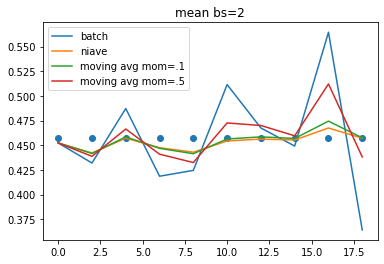

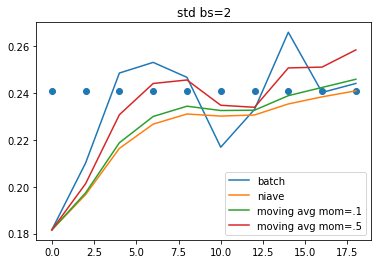

In [17]:
plot(2)

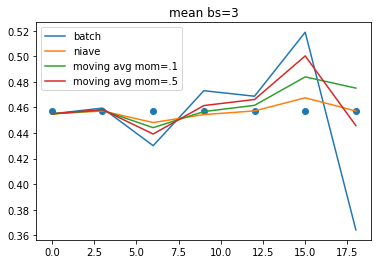

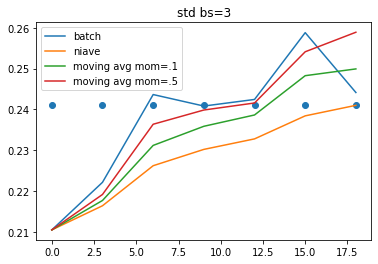

In [18]:
plot(3)

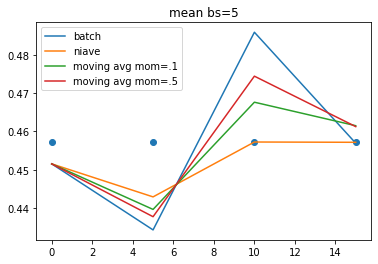

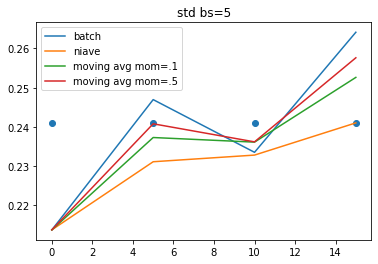

In [19]:
plot(5)